In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3



# Load data

In [5]:
df_single = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_single_ko.pkl')
df_double = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_double.pkl')

# Model training on t=0

In [6]:
cols = ['cellMass', 'growth', 'dryMass', 'waterMass', 'dnaMass', 'cytosol_mass',
       'tRnaMass', 'extracellular_mass', 'rRnaMass', 'proteinMass',
       'projection_mass', 'rnaMass', 'outer_membrane_mass', 'flagellum',
       'pilus_mass', 'cellVolume', 'inner_membrane_mass', 'mRnaMass',
       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
       'periplasm_mass']

#this is for the cells that survive only for 1 time-step
df_features2 = df_single[df_single['cellMass'].str.len().isna()]
    

#this is for the cells that survive for more than 1 time-step
df_features1 = df_single[~df_single['cellMass'].str.len().isna()]

for c in cols:
    df_features1[c] = df_features1[c].apply(lambda x:x[0])


        
df_features = pd.concat([df_features1, df_features2])
df_features['growth'] = df_features['growth'].fillna(0)
df_features = df_features.drop(columns=['processMassDifferences', 'time'])

In [7]:
df_features.columns

Index(['cellMass', 'growth', 'dryMass', 'waterMass', 'dnaMass', 'cytosol_mass',
       'tRnaMass', 'extracellular_mass', 'rRnaMass', 'proteinMass',
       'projection_mass', 'rnaMass', 'outer_membrane_mass', 'flagellum',
       'pilus_mass', 'cellVolume', 'inner_membrane_mass', 'mRnaMass',
       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
       'periplasm_mass', 'label', 'cell_path', 'generation', 'gene_id', 'seed',
       'cell', 'gene_name', 'label_death', 'label_lifetime'],
      dtype='object')

In [8]:
from sklearn.model_selection import GroupShuffleSplit

y = df_features.label_death.replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
X = df_features.drop(['label', 'cell_path', 'generation', 'seed', 'instantaniousGrowthRate', 'cell', 'gene_name', 'label_lifetime', 'label_death', 'growth'], axis=1)

gs = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=6)

gen = list(next(gs.split(X, y, groups=X.gene_id)))
train_ix = gen[0]
test_ix = gen[1]

X_train = X.iloc[train_ix]
y_train = y.iloc[train_ix]

X_test = X.iloc[test_ix]
y_test = y.iloc[test_ix]

In [9]:
y_train.value_counts()

label_death
non_essential    438
essential        300
Name: count, dtype: int64

In [10]:
map_label = {'non_essential': 0, 'essential':1}

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression


gkf_cv = GroupKFold(n_splits=5)
f1_tr = []
f1_eval = []

m_depth = [11, 13, 15, 17, 19, 21]
n_est = [22, 24, 26, 28]
m_leaf = [15, 16, 17, 18, 19]
comb = [(i, j, z) for i in m_depth for j in n_est for z in m_leaf]
res = []

for k in comb:
    clf = RandomForestClassifier(max_depth=k[0], n_estimators=k[1], random_state=0, max_leaf_nodes=k[2])
    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X_train.drop(columns=['gene_id']).astype(float), groups=X_train['gene_id'])):
        X_tr = X_train.drop(columns=[ 'gene_id']).iloc[ix_train]
        y_tr = y_train.iloc[ix_train]
        X_te = X_train.drop(columns=[ 'gene_id']).iloc[ix_test]
        y_te = y_train.iloc[ix_test]
        clf.fit(X_tr, y_tr)
        cnf1 = confusion_matrix(y_tr, clf.predict(X_tr))
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf1,
                                   display_labels=clf.classes_)
        
        f1_tr.append(f1_score(y_tr, clf.predict(X_tr), pos_label='essential'))
        cnf2 = confusion_matrix(y_te, clf.predict(X_te))
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf2,
                                   display_labels=clf.classes_)
        
        f1_eval.append(f1_score(y_te, clf.predict(X_te), pos_label='essential'))
    
    print('Avg eval ', sum(f1_eval)/len(f1_eval))
    
    clf.fit(X_train.drop(columns=['gene_id']), y_train)
    
    print('F1 score training ', f1_score(y_train, clf.predict(X_train.drop(columns=[ 'gene_id'])),  pos_label='essential'))
        
    print('F1 score testing', f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])),  pos_label='essential'))
    print(k)
    print('===========================')
    res.append([f1_score(y_train, clf.predict(X_train.drop(columns=[ 'gene_id'])),  pos_label='essential'), 
                f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])),  pos_label='essential'), k])


Avg eval  0.6329459200949711
F1 score training  0.7466666666666667
F1 score testing 0.7432432432432432
(11, 22, 15)
Avg eval  0.6297553860072163
F1 score training  0.7386363636363636
F1 score testing 0.7432432432432432
(11, 22, 16)
Avg eval  0.628291335100361
F1 score training  0.7556390977443609
F1 score testing 0.7432432432432432
(11, 22, 17)
Avg eval  0.6287267644585338
F1 score training  0.7611940298507464
F1 score testing 0.7297297297297298
(11, 22, 18)
Avg eval  0.6306560047982849
F1 score training  0.7666666666666667
F1 score testing 0.7172413793103448
(11, 22, 19)
Avg eval  0.6291805585638311
F1 score training  0.7428571428571429
F1 score testing 0.7310344827586208
(11, 24, 15)
Avg eval  0.6280002101232368
F1 score training  0.7448015122873345
F1 score testing 0.7346938775510204
(11, 24, 16)
Avg eval  0.6271268442524751
F1 score training  0.7523629489603024
F1 score testing 0.7482993197278912
(11, 24, 17)
Avg eval  0.6269992193502714
F1 score training  0.7565543071161049
F1 sco

In [12]:
sorted_list = sorted(res, key=lambda x: x[1], reverse=True)
sorted_list

[[0.7509433962264151, 0.7567567567567567, (13, 24, 17)],
 [0.7509433962264151, 0.7567567567567567, (15, 24, 17)],
 [0.7509433962264151, 0.7567567567567567, (17, 24, 17)],
 [0.7509433962264151, 0.7567567567567567, (19, 24, 17)],
 [0.7509433962264151, 0.7567567567567567, (21, 24, 17)],
 [0.7532956685499058, 0.7516778523489933, (13, 22, 17)],
 [0.7532956685499058, 0.7516778523489933, (15, 22, 17)],
 [0.7532956685499058, 0.7516778523489933, (17, 22, 17)],
 [0.7532956685499058, 0.7516778523489933, (19, 22, 17)],
 [0.7532956685499058, 0.7516778523489933, (21, 22, 17)],
 [0.7523629489603024, 0.7482993197278912, (11, 24, 17)],
 [0.7537878787878788, 0.7482993197278912, (13, 26, 18)],
 [0.7622641509433963, 0.7482993197278912, (13, 26, 19)],
 [0.7537878787878788, 0.7482993197278912, (15, 26, 18)],
 [0.7622641509433963, 0.7482993197278912, (15, 26, 19)],
 [0.7537878787878788, 0.7482993197278912, (17, 26, 18)],
 [0.7622641509433963, 0.7482993197278912, (17, 26, 19)],
 [0.7537878787878788, 0.7482993

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier


gkf_cv = GroupKFold(n_splits=5)
f1_tr = []
f1_eval = []
m_depth = [6, 8, 10, 12]
min_child_w = [18, 20, 22, 24]
n_estimators = [20, 30, 40, 50]
comb = [(i, j, z) for i in m_depth for j in min_child_w for z in n_estimators]
res = []

for k in comb:
    clf = xgb.XGBClassifier(max_depth=k[0], min_child_weight=k[1], n_estimators=k[2], learning_rate=0.1, verbosity=0)
    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X_train.drop(columns=['gene_id']).astype(float), groups=X_train['gene_id'])):
        X_train = X.iloc[train_ix]
        y_train = y.iloc[train_ix]

        X_test = X.iloc[test_ix]
        y_test = y.iloc[test_ix]
        
        X_tr = X_train.drop(columns=['gene_id']).iloc[ix_train].astype(float)
        y_tr = y_train.iloc[ix_train]
        X_te = X_train.drop(columns=['gene_id']).iloc[ix_test].astype(float)
        y_te = y_train.iloc[ix_test]
        y_tr = [map_label[x] for x in y_tr]
        y_te = [map_label[x] for x in y_te]
        clf.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=0)
    
        f1_tr.append(f1_score(y_tr, clf.predict(X_tr), pos_label=1))
        
        f1_eval.append(f1_score(y_te, clf.predict(X_te), pos_label=1))
    
    print(sum(f1_eval)/len(f1_eval))
    
    y_train = [map_label[x] for x in y_train]
    y_test = [map_label[x] for x in y_test]
    
    clf.fit(X_train.drop(columns=['gene_id']).astype(float), y_train, eval_set=[(X_test.drop(columns=['gene_id']).astype(float), y_test)], verbose=0)
    
    print(f1_score(y_train, clf.predict(X_train.drop(columns=['gene_id']).astype(float)),  pos_label=1))
        
    
    print(f1_score(y_test, clf.predict(X_test.drop(columns=['gene_id']).astype(float)),  pos_label=1))
    print(k)
    print('=======================')
    res.append([f1_score(y_train, clf.predict(X_train.drop(columns=[ 'gene_id']).astype(float)),  pos_label=1), 
                f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id']).astype(float)),  pos_label=1), k])




0.6212521728876869
0.6994328922495274
0.7074829931972789
(6, 18, 20)
0.6260492902914612
0.7140186915887851
0.7200000000000001
(6, 18, 30)
0.6310910921323496
0.725598526703499
0.7114093959731543
(6, 18, 40)
0.633449502427253
0.7391304347826089
0.7200000000000001
(6, 18, 50)
0.6314393422136356
0.6883365200764818
0.7019867549668874
(6, 20, 20)
0.6289146718949042
0.7058823529411764
0.7435897435897436
(6, 20, 30)
0.6277739415513878
0.708955223880597
0.7483870967741935
(6, 20, 40)
0.6276779429396468
0.725598526703499
0.735483870967742
(6, 20, 50)
0.6233418486370977
0.7038461538461538
0.689655172413793
(6, 22, 20)
0.6209453178212708
0.7124304267161411
0.7027027027027026
(6, 22, 30)
0.6218200536223027
0.7192660550458716
0.728476821192053
(6, 22, 40)
0.62267149168837
0.7229357798165137
0.7200000000000001
(6, 22, 50)
0.6220977253589629
0.6719056974459725
0.689655172413793
(6, 24, 20)
0.6207763993060488
0.698292220113852
0.7248322147651007
(6, 24, 30)
0.6210482536831545
0.7188081936685288
0.72847

In [14]:
sorted_list = sorted(res, key=lambda x: x[1], reverse=True)
sorted_list

[[0.708955223880597, 0.7483870967741935, (6, 20, 40)],
 [0.708955223880597, 0.7483870967741935, (8, 20, 40)],
 [0.708955223880597, 0.7483870967741935, (10, 20, 40)],
 [0.708955223880597, 0.7483870967741935, (12, 20, 40)],
 [0.7058823529411764, 0.7435897435897436, (6, 20, 30)],
 [0.7058823529411764, 0.7435897435897436, (8, 20, 30)],
 [0.7058823529411764, 0.7435897435897436, (10, 20, 30)],
 [0.7058823529411764, 0.7435897435897436, (12, 20, 30)],
 [0.725598526703499, 0.735483870967742, (6, 20, 50)],
 [0.725598526703499, 0.735483870967742, (8, 20, 50)],
 [0.725598526703499, 0.735483870967742, (10, 20, 50)],
 [0.725598526703499, 0.735483870967742, (12, 20, 50)],
 [0.7192660550458716, 0.728476821192053, (6, 22, 40)],
 [0.7188081936685288, 0.728476821192053, (6, 24, 40)],
 [0.7192660550458716, 0.728476821192053, (8, 22, 40)],
 [0.7188081936685288, 0.728476821192053, (8, 24, 40)],
 [0.7192660550458716, 0.728476821192053, (10, 22, 40)],
 [0.7188081936685288, 0.728476821192053, (10, 24, 40)],
 [

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

gkf_cv = GroupKFold(n_splits=5)
f1_tr = []
f1_eval = []

X_train = X.iloc[train_ix]
y_train = y.iloc[train_ix]
X_test = X.iloc[test_ix]
y_test = y.iloc[test_ix]

for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X_train.drop(columns=[ 'gene_id']).astype(float), groups=X_train['gene_id'])):
        clf = KNeighborsClassifier(n_neighbors=k)
        X_tr = X_train.drop(columns=[ 'gene_id']).iloc[ix_train]
        y_tr = y_train.iloc[ix_train]
        X_te = X_train.drop(columns=[ 'gene_id']).iloc[ix_test]
        y_te = y_train.iloc[ix_test]
        clf.fit(X_tr, y_tr)
        
        f1_tr.append(f1_score(y_tr, clf.predict(X_tr), pos_label='essential'))
        f1_eval.append(f1_score(y_te, clf.predict(X_te), pos_label='essential'))

    clf.fit(X_train.drop(columns=['gene_id']), y_train)
    print(f1_score(y_train, clf.predict(X_train.drop(columns=['gene_id'])),  pos_label='essential'))
        
    cnf_test = confusion_matrix(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_test,
                                   display_labels=clf.classes_)
    print(f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])),  pos_label='essential'))
    
    FP = cnf_test.sum(axis=0) - np.diag(cnf_test)  
    FN = cnf_test.sum(axis=1) - np.diag(cnf_test)
    TP = np.diag(cnf_test)
    TN = cnf_test.sum() - (FP + FN + TP)
    print(k)
    print('False negative rate for testing is ' + str( FN/(TP+FN)))


1.0
0.7142857142857143
1
False negative rate for testing is [0.28571429 0.23529412]
0.8264462809917354
0.7357512953367876
2
False negative rate for testing is [0.1547619  0.37254902]
0.7915194346289753
0.7544910179640718
3
False negative rate for testing is [0.25       0.19607843]
0.7621951219512195
0.7282608695652173
4
False negative rate for testing is [0.20238095 0.32352941]
0.7353463587921847
0.7169811320754718
5
False negative rate for testing is [0.32142857 0.17647059]
0.7351524879614766
0.7558139534883721
6
False negative rate for testing is [0.22619048 0.2254902 ]
0.7140319715808171
0.6973684210526316
7
False negative rate for testing is [0.36904762 0.14705882]
0.7186991869918701
0.6982248520710058
8
False negative rate for testing is [0.29761905 0.25490196]
0.6931407942238267
0.6578947368421053
9
False negative rate for testing is [0.4047619  0.17647059]
0.6878130217028381
0.6625766871165644
10
False negative rate for testing is [0.35714286 0.24509804]
0.6508226691042048
0.649

# Test final single KOs trained RF on all features

In [16]:
cols = ['cellMass', 'growth', 'dryMass', 'waterMass', 'dnaMass', 'cytosol_mass',
       'tRnaMass', 'extracellular_mass', 'rRnaMass', 'proteinMass',
       'projection_mass', 'rnaMass', 'outer_membrane_mass', 'flagellum',
       'pilus_mass', 'cellVolume', 'inner_membrane_mass', 'mRnaMass',
       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
       'periplasm_mass']

#this is for the cells that survive only for 1 time-step
df_features2 = df_single[df_single['cellMass'].str.len().isna()]
    

#this is for the cells that survive for more than 1 time-step
df_features1 = df_single[~df_single['cellMass'].str.len().isna()]

for c in cols:
    df_features1[c] = df_features1[c].apply(lambda x:x[-1])


        
df_features = pd.concat([df_features1, df_features2])
df_features['growth'] = df_features['growth'].fillna(0)
df_features = df_features.drop(columns=['processMassDifferences', 'time'])

In [17]:
from sklearn.model_selection import GroupShuffleSplit

y = df_features.label_death.replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
X = df_features.drop([ 'label', 'cell_path', 'generation', 'seed', 'instantaniousGrowthRate',
                       'cell', 'gene_name', 'label_lifetime', 'label_death', 'growth'], axis=1)

gs = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=6)

gen = list(next(gs.split(X, y, groups=X.gene_id)))
train_ix = gen[0]
test_ix = gen[1]

X_train = X.iloc[train_ix]
y_train = y.iloc[train_ix]

X_test = X.iloc[test_ix]
y_test = y.iloc[test_ix]

In [18]:
y_train.value_counts()

label_death
non_essential    438
essential        300
Name: count, dtype: int64

In [19]:
gkf_cv = GroupKFold(n_splits=5)
f1_tr = []
f1_eval = []

m_depth = [3, 4, 6, 8, 11, 13]
n_est = [4, 6, 8, 9, 14]
m_leaf = [10, 12, 15]
comb = [(i, j, z) for i in m_depth for j in n_est for z in m_leaf]
res = []

for k in comb:
    clf = RandomForestClassifier(max_depth=k[0], n_estimators=k[1], random_state=0, max_leaf_nodes=k[2])
    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X_train.drop(columns=['gene_id']).astype(float), groups=X_train['gene_id'])):
        X_tr = X_train.drop(columns=[ 'gene_id']).iloc[ix_train]
        y_tr = y_train.iloc[ix_train]
        X_te = X_train.drop(columns=[ 'gene_id']).iloc[ix_test]
        y_te = y_train.iloc[ix_test]
        clf.fit(X_tr, y_tr)
        cnf1 = confusion_matrix(y_tr, clf.predict(X_tr))
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf1,
                                   display_labels=clf.classes_)
        
        f1_tr.append(f1_score(y_tr, clf.predict(X_tr), pos_label='essential'))
        cnf2 = confusion_matrix(y_te, clf.predict(X_te))
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf2,
                                   display_labels=clf.classes_)
        
        f1_eval.append(f1_score(y_te, clf.predict(X_te), pos_label='essential'))
    
    print('Avg eval ', sum(f1_eval)/len(f1_eval))
    
    clf.fit(X_train.drop(columns=['gene_id']), y_train)
    
    print('F1 score training ', f1_score(y_train, clf.predict(X_train.drop(columns=[ 'gene_id'])),  pos_label='essential'))
        
    print('F1 score testing', f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])),  pos_label='essential'))
    print(k)
    print('===========================')
    res.append([f1_score(y_train, clf.predict(X_train.drop(columns=[ 'gene_id'])),  pos_label='essential'), 
                f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])),  pos_label='essential'), k])


Avg eval  0.902572979992185
F1 score training  0.919210053859964
F1 score testing 0.925
(3, 4, 10)
Avg eval  0.9025729799921848
F1 score training  0.919210053859964
F1 score testing 0.925
(3, 4, 12)
Avg eval  0.9025729799921849
F1 score training  0.919210053859964
F1 score testing 0.925
(3, 4, 15)
Avg eval  0.9040734134130879
F1 score training  0.919210053859964
F1 score testing 0.925
(3, 6, 10)
Avg eval  0.9049736734656298
F1 score training  0.919210053859964
F1 score testing 0.925
(3, 6, 12)
Avg eval  0.9055738468339911
F1 score training  0.919210053859964
F1 score testing 0.925
(3, 6, 15)
Avg eval  0.9056944943497054
F1 score training  0.9175627240143369
F1 score testing 0.925
(3, 8, 10)
Avg eval  0.905784979986491
F1 score training  0.9175627240143369
F1 score testing 0.925
(3, 8, 12)
Avg eval  0.9058553577039908
F1 score training  0.9175627240143369
F1 score testing 0.925
(3, 8, 15)
Avg eval  0.9056918796582106
F1 score training  0.9175627240143369
F1 score testing 0.925
(3, 9, 10

In [20]:
sorted_list = sorted(res, key=lambda x: x[1], reverse=True)
sorted_list

[[0.919210053859964, 0.925, (3, 4, 10)],
 [0.919210053859964, 0.925, (3, 4, 12)],
 [0.919210053859964, 0.925, (3, 4, 15)],
 [0.919210053859964, 0.925, (3, 6, 10)],
 [0.919210053859964, 0.925, (3, 6, 12)],
 [0.919210053859964, 0.925, (3, 6, 15)],
 [0.9175627240143369, 0.925, (3, 8, 10)],
 [0.9175627240143369, 0.925, (3, 8, 12)],
 [0.9175627240143369, 0.925, (3, 8, 15)],
 [0.9175627240143369, 0.925, (3, 9, 10)],
 [0.9175627240143369, 0.925, (3, 9, 12)],
 [0.9175627240143369, 0.925, (3, 9, 15)],
 [0.9175627240143369, 0.925, (3, 14, 10)],
 [0.9175627240143369, 0.925, (3, 14, 12)],
 [0.9175627240143369, 0.925, (3, 14, 15)],
 [0.9228007181328546, 0.925, (4, 4, 10)],
 [0.9228007181328546, 0.925, (4, 4, 12)],
 [0.9228007181328546, 0.925, (4, 4, 15)],
 [0.9208633093525179, 0.925, (4, 6, 10)],
 [0.9208633093525179, 0.925, (4, 6, 12)],
 [0.9208633093525179, 0.925, (4, 6, 15)],
 [0.919210053859964, 0.925, (4, 8, 10)],
 [0.9208633093525179, 0.925, (4, 8, 12)],
 [0.9208633093525179, 0.925, (4, 8, 15

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier


gkf_cv = GroupKFold(n_splits=5)
f1_tr = []
f1_eval = []
m_depth = [6, 8, 10, 12]
min_child_w = [18, 20, 22, 24]
n_estimators = [20, 30, 40, 50]
comb = [(i, j, z) for i in m_depth for j in min_child_w for z in n_estimators]
res = []

for k in comb:
    clf = xgb.XGBClassifier(max_depth=k[0], min_child_weight=k[1], n_estimators=k[2], learning_rate=0.1, verbosity=0)
    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X_train.drop(columns=['gene_id']).astype(float), groups=X_train['gene_id'])):
        X_train = X.iloc[train_ix]
        y_train = y.iloc[train_ix]

        X_test = X.iloc[test_ix]
        y_test = y.iloc[test_ix]
        
        X_tr = X_train.drop(columns=['gene_id']).iloc[ix_train].astype(float)
        y_tr = y_train.iloc[ix_train]
        X_te = X_train.drop(columns=['gene_id']).iloc[ix_test].astype(float)
        y_te = y_train.iloc[ix_test]
        y_tr = [map_label[x] for x in y_tr]
        y_te = [map_label[x] for x in y_te]
        clf.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=0)
    
        f1_tr.append(f1_score(y_tr, clf.predict(X_tr), pos_label=1))
        
        f1_eval.append(f1_score(y_te, clf.predict(X_te), pos_label=1))
    
    print(sum(f1_eval)/len(f1_eval))
    
    y_train = [map_label[x] for x in y_train]
    y_test = [map_label[x] for x in y_test]
    
    clf.fit(X_train.drop(columns=['gene_id']).astype(float), y_train, eval_set=[(X_test.drop(columns=['gene_id']).astype(float), y_test)], verbose=0)
    
    print(f1_score(y_train, clf.predict(X_train.drop(columns=['gene_id']).astype(float)),  pos_label=1))
        
    
    print(f1_score(y_test, clf.predict(X_test.drop(columns=['gene_id']).astype(float)),  pos_label=1))
    print(k)
    print('=======================')
    res.append([f1_score(y_train, clf.predict(X_train.drop(columns=[ 'gene_id']).astype(float)),  pos_label=1), 
                f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id']).astype(float)),  pos_label=1), k])




0.9057632769707075
0.912655971479501
0.925
(6, 18, 20)
0.9057632769707075
0.912655971479501
0.925
(6, 18, 30)
0.9057632769707076
0.912655971479501
0.925
(6, 18, 40)
0.9057632769707075
0.912655971479501
0.925
(6, 18, 50)
0.9057632769707074
0.912655971479501
0.925
(6, 20, 20)
0.9057632769707074
0.912655971479501
0.925
(6, 20, 30)
0.9057632769707072
0.912655971479501
0.925
(6, 20, 40)
0.9057632769707071
0.912655971479501
0.925
(6, 20, 50)
0.9057632769707069
0.912655971479501
0.925
(6, 22, 20)
0.9057632769707068
0.912655971479501
0.925
(6, 22, 30)
0.9056230315412052
0.912655971479501
0.925
(6, 22, 40)
0.9053797095528622
0.912655971479501
0.925
(6, 22, 50)
0.90540921473885
0.912655971479501
0.925
(6, 24, 20)
0.9054345048982684
0.912655971479501
0.925
(6, 24, 30)
0.9052368177105485
0.912655971479501
0.925
(6, 24, 40)
0.9049690033234752
0.912655971479501
0.925
(6, 24, 50)
0.9050157253027242
0.912655971479501
0.925
(8, 18, 20)
0.9050572559509455
0.912655971479501
0.925
(8, 18, 30)
0.9050944149

In [22]:
sorted_list = sorted(res, key=lambda x: x[1], reverse=True)
sorted_list

[[0.912655971479501, 0.925, (6, 18, 20)],
 [0.912655971479501, 0.925, (6, 18, 30)],
 [0.912655971479501, 0.925, (6, 18, 40)],
 [0.912655971479501, 0.925, (6, 18, 50)],
 [0.912655971479501, 0.925, (6, 20, 20)],
 [0.912655971479501, 0.925, (6, 20, 30)],
 [0.912655971479501, 0.925, (6, 20, 40)],
 [0.912655971479501, 0.925, (6, 20, 50)],
 [0.912655971479501, 0.925, (6, 22, 20)],
 [0.912655971479501, 0.925, (6, 22, 30)],
 [0.912655971479501, 0.925, (6, 22, 40)],
 [0.912655971479501, 0.925, (6, 22, 50)],
 [0.912655971479501, 0.925, (6, 24, 20)],
 [0.912655971479501, 0.925, (6, 24, 30)],
 [0.912655971479501, 0.925, (6, 24, 40)],
 [0.912655971479501, 0.925, (6, 24, 50)],
 [0.912655971479501, 0.925, (8, 18, 20)],
 [0.912655971479501, 0.925, (8, 18, 30)],
 [0.912655971479501, 0.925, (8, 18, 40)],
 [0.912655971479501, 0.925, (8, 18, 50)],
 [0.912655971479501, 0.925, (8, 20, 20)],
 [0.912655971479501, 0.925, (8, 20, 30)],
 [0.912655971479501, 0.925, (8, 20, 40)],
 [0.912655971479501, 0.925, (8, 20

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

gkf_cv = GroupKFold(n_splits=5)
f1_tr = []
f1_eval = []

X_train = X.iloc[train_ix]
y_train = y.iloc[train_ix]
X_test = X.iloc[test_ix]
y_test = y.iloc[test_ix]

for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X_train.drop(columns=[ 'gene_id']).astype(float), groups=X_train['gene_id'])):
        clf = KNeighborsClassifier(n_neighbors=k)
        X_tr = X_train.drop(columns=[ 'gene_id']).iloc[ix_train]
        y_tr = y_train.iloc[ix_train]
        X_te = X_train.drop(columns=[ 'gene_id']).iloc[ix_test]
        y_te = y_train.iloc[ix_test]
        clf.fit(X_tr, y_tr)
        
        f1_tr.append(f1_score(y_tr, clf.predict(X_tr), pos_label='essential'))
        f1_eval.append(f1_score(y_te, clf.predict(X_te), pos_label='essential'))

    clf.fit(X_train.drop(columns=['gene_id']), y_train)
    print(f1_score(y_train, clf.predict(X_train.drop(columns=['gene_id'])),  pos_label='essential'))
        
    cnf_test = confusion_matrix(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_test,
                                   display_labels=clf.classes_)
    print(f1_score(y_test, clf.predict(X_test.drop(columns=[ 'gene_id'])),  pos_label='essential'))
    
    FP = cnf_test.sum(axis=0) - np.diag(cnf_test)  
    FN = cnf_test.sum(axis=1) - np.diag(cnf_test)
    TP = np.diag(cnf_test)
    TN = cnf_test.sum() - (FP + FN + TP)
    print(k)
    print('False negative rate for testing is ' + str( FN/(TP+FN)))


1.0
0.9101796407185628
1
False negative rate for testing is [0.0952381  0.06862745]
0.9259259259259259
0.8813559322033899
2
False negative rate for testing is [0.07142857 0.14705882]
0.9184397163120568
0.925
3
False negative rate for testing is [0.11904762 0.01960784]
0.9220103986135183
0.9024390243902439
4
False negative rate for testing is [0.11904762 0.05882353]
0.9090909090909092
0.925
5
False negative rate for testing is [0.11904762 0.01960784]
0.9129662522202487
0.925
6
False negative rate for testing is [0.11904762 0.01960784]
0.910394265232975
0.925
7
False negative rate for testing is [0.11904762 0.01960784]
0.9087656529516995
0.925
8
False negative rate for testing is [0.11904762 0.01960784]
0.906810035842294
0.925
9
False negative rate for testing is [0.11904762 0.01960784]
0.9055258467023173
0.925
10
False negative rate for testing is [0.11904762 0.01960784]
0.9087656529516995
0.925
11
False negative rate for testing is [0.11904762 0.01960784]
0.9055258467023173
0.925
12
Fa

# Perform feature engineering

In [24]:
cols = ['cellMass', 'growth', 'dryMass', 'waterMass', 'dnaMass', 'cytosol_mass',
       'tRnaMass', 'extracellular_mass', 'rRnaMass', 'proteinMass',
       'projection_mass', 'rnaMass', 'outer_membrane_mass', 'flagellum',
       'pilus_mass', 'cellVolume', 'inner_membrane_mass', 'mRnaMass',
       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
       'periplasm_mass']

#this is for the cells that survive only for 1 time-step
df_features2 = df_single[df_single['cellMass'].str.len().isna()]
for c in cols:
    df_features2[c] = df_features2[c].astype(float)
    

#this is for the cells that survive for more than 1 time-step
df_features1 = df_single[~df_single['cellMass'].str.len().isna()]

for c in cols:
    df_features1[c] = df_features1[c].apply(lambda x:x[-1])


        
df_features = pd.concat([df_features1,df_features2])
df_features['growth'] = df_features['growth'].fillna(0)
df_features = df_features.drop(columns=['processMassDifferences', 'time'])

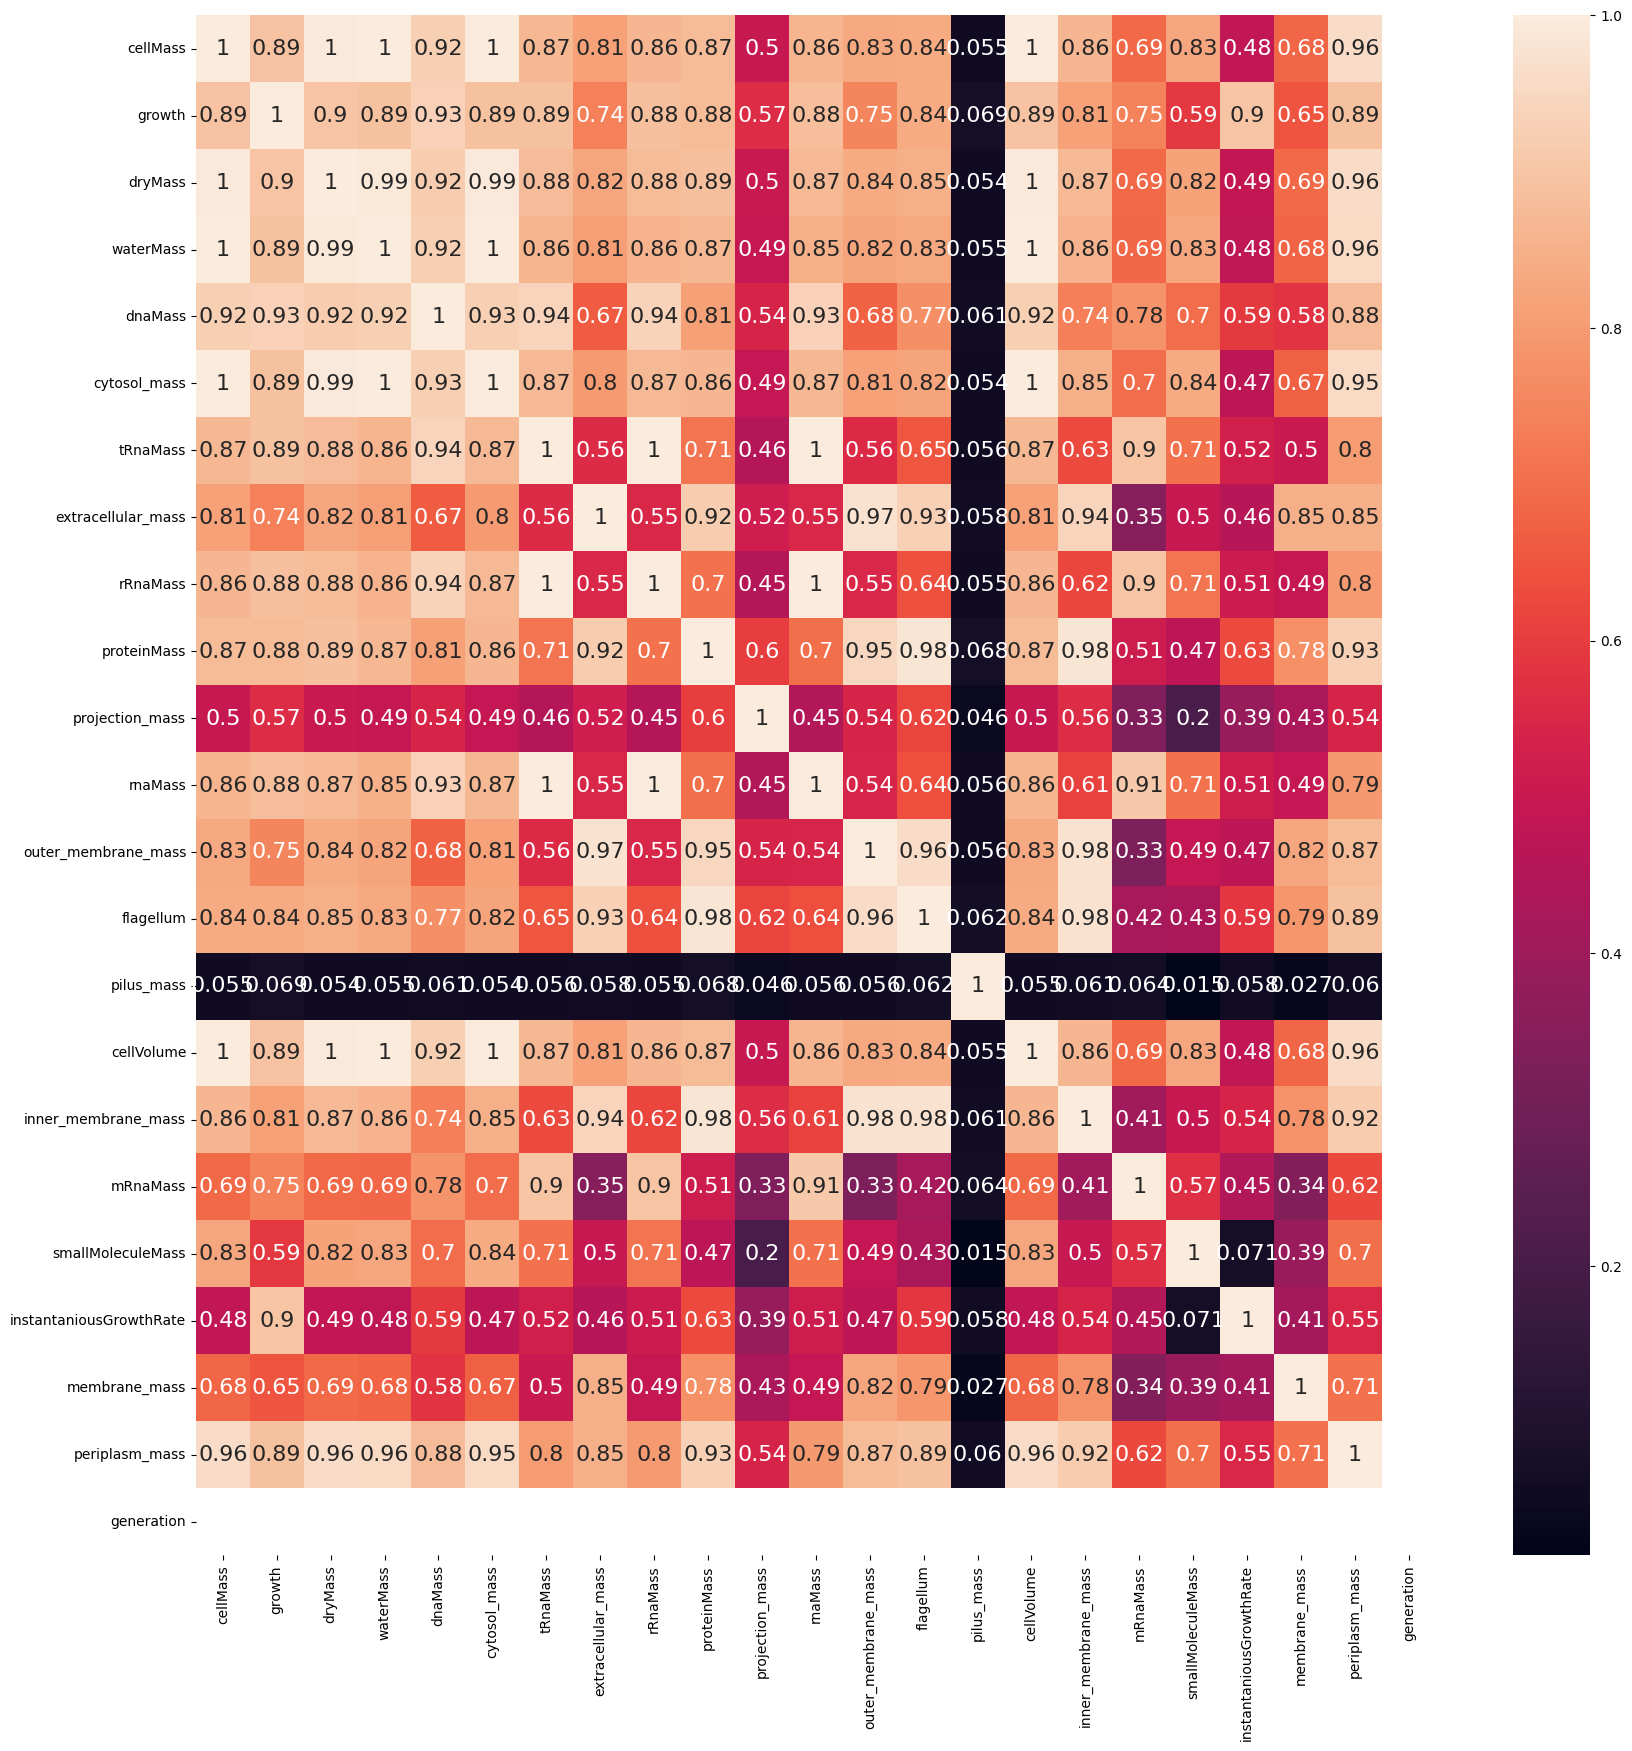

In [25]:
import seaborn as sn

corr_matrix = df_features.drop(columns=['label', 'cell_path', 'cell',
       'gene_id', 'seed', 'label_death', 
       'label_lifetime', 'gene_name']).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df_features = df_features.drop(to_drop, axis=1)


fig, ax = plt.subplots(figsize=(20,20))  
svm = sn.heatmap(corr_matrix, annot=True,ax =ax,annot_kws={"size":16})

plt.show()
figure = svm.get_figure() 
figure.savefig('corr_matrix.png',bbox_inches="tight")

In [26]:
len(to_drop)

10

# RF classifier

In [27]:
from sklearn.model_selection import GroupShuffleSplit
plt.rcParams["figure.figsize"] = (1.8, 2)

X = df_features.drop([ 'label', 'cell', 'seed', 'instantaniousGrowthRate',
                       'label_lifetime', 'generation'], axis=1)
X.label_death = X.label_death.replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
#based on an intial RF model, the following features seemed the most important to correctly classify
X = X[['cellMass', 'dnaMass', 'membrane_mass', 'extracellular_mass', 'gene_id', 'cell_path', 'label_death', 'gene_name']]
y=df_features.label_death.replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
gs = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=6)

gen = list(next(gs.split(X, y, groups=X.gene_id)))
train_ix = gen[0]
test_ix = gen[1]

X_train = X.iloc[train_ix].drop(columns=['label_death'])
y_train = y.iloc[train_ix]

X_test = X.iloc[test_ix].drop(columns=['label_death'])
y_test = y.iloc[test_ix]

In [28]:
set(y_train)

{'essential', 'non_essential'}

In [29]:
y_train.value_counts()

label_death
non_essential    438
essential        300
Name: count, dtype: int64

In [30]:
y_test.value_counts()

label_death
non_essential    102
essential         84
Name: count, dtype: int64

In [31]:
with open("trainig_genes.csv", "w") as output:
    output.write(str(list(set(X_train['gene_name']))))
with open("testing_genes.csv", "w") as output:
    output.write(str(list(set(X_test['gene_name']))))

AVG cross-validation F1-score  0.9034457952196113
Confussion matrix for the training set
[[259  41]
 [  2 436]]


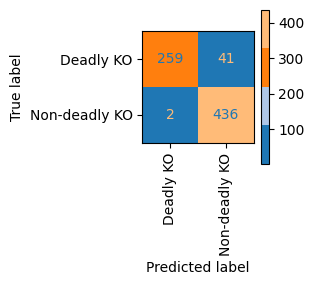

Training data F1-score  0.9233511586452763
Confusion matrix for the test set
[[ 74  10]
 [  2 100]]


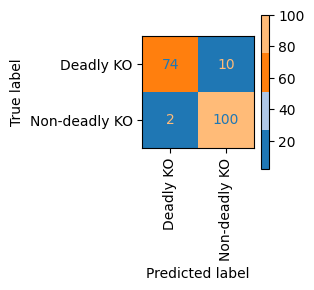

F1 score for the test set is 0.925


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
import matplotlib
colors = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab20").colors[:4])

gkf_cv = GroupKFold(n_splits=5)
f1_tr = []
f1_eval = []
for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']).astype(float), groups=X_train['gene_id'])):
    

    clf = RandomForestClassifier(max_depth=4, n_estimators=3, random_state=0)
    X_tr = X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']).iloc[ix_train]
    y_tr = y_train.iloc[ix_train]
    X_te = X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']).iloc[ix_test]
    y_te = y_train.iloc[ix_test]
    clf.fit(X_tr, y_tr)
    cnf1 = confusion_matrix(y_tr, clf.predict(X_tr))
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf1,
                               display_labels=clf.classes_)
    f1_tr.append(f1_score(y_tr, clf.predict(X_tr), pos_label='essential'))
    cnf2 = confusion_matrix(y_te, clf.predict(X_te))
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf2,
                               display_labels=clf.classes_)
    f1_eval.append(f1_score(y_te, clf.predict(X_te), pos_label='essential'))

print('AVG cross-validation F1-score ', sum(f1_eval)/len(f1_eval))
clf.fit(X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']), y_train)
print('Confussion matrix for the training set')
cnf_tr = confusion_matrix(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id', 'gene_name'])))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_tr,
                               display_labels=['Deadly KO', 'Non-deadly KO'])
print(cnf_tr)
disp.plot(cmap=colors, xticks_rotation='vertical')
plt.show()
disp.figure_.savefig('confusion_matrix_training_init.png', bbox_inches="tight", dpi=600)

print('Training data F1-score ', f1_score(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id', 'gene_name'])),  pos_label='essential'))
    
print('Confusion matrix for the test set')
cnf_test = confusion_matrix(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id', 'gene_name'])))
print(cnf_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_test,
                               display_labels=['Deadly KO', 'Non-deadly KO'])
disp.plot(cmap=colors, xticks_rotation='vertical')
plt.show()
disp.figure_.savefig('confusion_matrix_test_init.png', bbox_inches="tight", dpi=600)
print('F1 score for the test set is ' + str(f1_score(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id', 'gene_name'])),  pos_label='essential')))

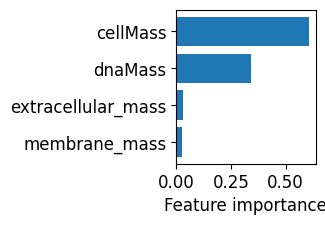

In [33]:
plt.rcParams["figure.figsize"] = (1.8, 2)
features = X_train.columns
f_i = list(zip(features, clf.feature_importances_))
f_i.sort(key = lambda x : x[1], reverse=False)

plt.barh(*zip(*f_i), )
plt.xticks(rotation = 'horizontal',fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Feature importance', fontsize=12)
plt.savefig('feat_importance_rf_init.png', bbox_inches="tight")
plt.savefig('feat_importance_rf_init.eps', bbox_inches="tight", format='eps')
plt.show()

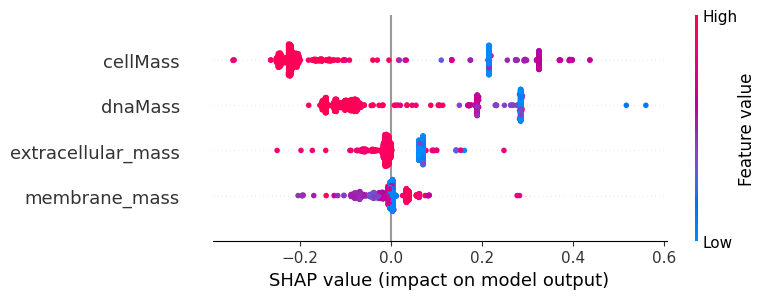

In [34]:
import shap
# compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']))

shap.summary_plot(shap_values[0], X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']).values,   feature_names = list(X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']).columns), show=False)

plt.savefig('shap_init.png', dpi=600,bbox_inches="tight")
plt.savefig('shap_init.eps', bbox_inches="tight", format='eps')

In [35]:
#Check which points are miss-classified
predictions = clf.predict(X_train.drop(columns=['cell_path', 'gene_id', 'gene_name']).values)
inputs = X_train['cell_path']
labels=y_train
wrong_class_gene = []
for input, prediction, label in zip(inputs, predictions, labels):
    if prediction != label:
        try:
            wrong_class_gene.append(input.split('/')[5].split('_')[3])
            print(input.split('/')[5].split('_')[3], 'has been classified as ', prediction, 'and should be ', label)
        except:
            wrong_class_gene.append(input.split('/')[9].split('_')[3])
            print(input.split('/')[9].split('_')[3], 'has been classified as ', prediction, 'and should be ', label)

                   
    

atpE has been classified as  essential and should be  non_essential
murJ has been classified as  non_essential and should be  essential
ribB has been classified as  non_essential and should be  essential
cpdA has been classified as  non_essential and should be  essential
lpxL has been classified as  non_essential and should be  essential
nhaA has been classified as  non_essential and should be  essential
rcnA has been classified as  non_essential and should be  essential
glcE has been classified as  non_essential and should be  essential
xanQ has been classified as  non_essential and should be  essential
livJ has been classified as  non_essential and should be  essential
csdA has been classified as  non_essential and should be  essential
cyoE has been classified as  non_essential and should be  essential
mltC has been classified as  non_essential and should be  essential
atpA has been classified as  essential and should be  non_essential
gltA has been classified as  non_essential and s

In [36]:
#Check which points are miss-classified
predictions = clf.predict(X_test.drop(columns=['cell_path', 'gene_id', 'gene_name']).values)
inputs = X_test['cell_path']
labels=y_test
wrong_class_gene = []
for input, prediction, label in zip(inputs, predictions, labels):
    if prediction != label:
        try:
            wrong_class_gene.append(input.split('/')[5].split('_')[3])
            print(input.split('/')[5].split('_')[3], 'has been classified as ', prediction, 'and should be ', label)
        except:
            wrong_class_gene.append(input.split('/')[9].split('_')[3])
            print(input.split('/')[9].split('_')[3], 'has been classified as ', prediction, 'and should be ', label)

                   
    

atpF has been classified as  essential and should be  non_essential
potB has been classified as  non_essential and should be  essential
livG has been classified as  non_essential and should be  essential
aldA has been classified as  non_essential and should be  essential
aldA has been classified as  non_essential and should be  essential
potB has been classified as  non_essential and should be  essential
livG has been classified as  non_essential and should be  essential
atpF has been classified as  essential and should be  non_essential
aroP has been classified as  non_essential and should be  essential
tmk has been classified as  non_essential and should be  essential
aroP has been classified as  non_essential and should be  essential
tmk has been classified as  non_essential and should be  essential


In [37]:
# save the model to disk
filename = 'rf_model_surrogate.sav'
pickle.dump(clf, open(filename, 'wb'))

## Test on double KOs

In [38]:
cols = ['cellMass', 'growth', 'dryMass', 'waterMass', 'dnaMass', 'cytosol_mass',
       'tRnaMass', 'extracellular_mass', 'rRnaMass', 'proteinMass',
       'projection_mass', 'rnaMass', 'outer_membrane_mass', 'flagellum',
       'pilus_mass', 'cellVolume', 'inner_membrane_mass', 'mRnaMass',
       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
       'periplasm_mass']

#this is for the cells that survive only for 1 time-step
df_double1 = df_double[df_double['cellMass'].str.len().isna()]
for c in cols:
    df_double1[c] = df_double1[c].astype(float)
    

#this is for the cells that survive for more than 1 time-step
df_double2 = df_double[~df_double['cellMass'].str.len().isna()]

for c in cols:
    df_double2[c] = df_double2[c].apply(lambda x:x[-1])


        
df_double_feat = pd.concat([df_double1, df_double2])
df_double_feat['growth'] = df_double_feat['growth'].fillna(0)
df_double_feat = df_double_feat.drop(columns=['processMassDifferences', 'time'])

In [39]:
df_double_label = df_double_feat['label_death'].replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
df_double_feat = df_double_feat[['cellMass', 'dnaMass', 'membrane_mass', 'extracellular_mass']]

[[64  9]
 [ 0 21]]


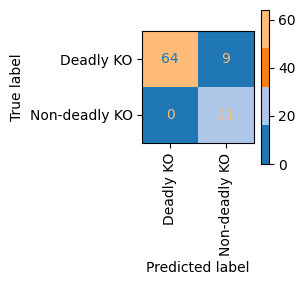

In [40]:
cnf_double = confusion_matrix(df_double_label, clf.predict(df_double_feat))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_double,
                               display_labels=['Deadly KO', 'Non-deadly KO'])
print(cnf_double)
disp.plot(cmap=colors, xticks_rotation='vertical', )
disp.figure_.savefig('confusion_matrix_doubleKO_init.png', bbox_inches="tight", dpi=600)


In [41]:
print('F1-score on the double KOs is ' + str(f1_score(df_double_label, clf.predict(df_double_feat),  pos_label='essential')))

F1-score on the double KOs is 0.9343065693430657


# Test on multiple KOs

## Apply model

In [42]:
from itertools import chain
df_multiple_test = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_multiple_test_perms_final.pkl')
df_multiple_train = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_multiple_train_perms_final.pkl')


In [43]:
df_multiple_train = df_multiple_train.drop_duplicates(subset='Combos')
df_multiple_test = df_multiple_test.drop_duplicates(subset='Combos')


In [44]:
set(list(chain(*[x.split() for x in list(df_multiple_train['Combos'])])))

{'5.0j', '5.0k', '5.0n', '5.0p', '5.0q', '5.0r', '5.0s', '5.0t'}

In [45]:
set(list(chain(*[x.split() for x in list(df_multiple_test['Combos'])])))

{'5.0a', '5.0b', '5.0c', '5.0e', '5.0g', '5.0i'}

In [46]:
df_multiple = pd.concat([df_multiple_train, df_multiple_test])
df_multiple = df_multiple.rename(columns={"label": "label_death"})
df_multiple_label = df_multiple['label_death'].replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
df_multiple_feat = df_multiple[['cellMass', 'dnaMass', 'membrane_mass', 'extracellular_mass']]

[[158  25]
 [ 42  86]]


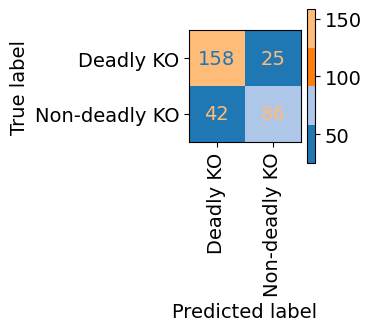

In [47]:
plt.rcParams["figure.figsize"] = (1.8, 2)
font = {'weight' : 'normal', 'size':14} 
plt.rc('font', **font)   
cnf_multiple = confusion_matrix(df_multiple_label, clf.predict(df_multiple_feat))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_multiple,
                               display_labels=['Deadly KO', 'Non-deadly KO'])
print(cnf_multiple)
disp.plot(cmap=colors, xticks_rotation='vertical', )
disp.figure_.savefig('confusion_matrix_multipleKO_init.png', bbox_inches="tight", dpi=600)


In [48]:
print('F1-score on the multiple KOs is ' + str(f1_score(df_multiple_label, clf.predict(df_multiple_feat),  pos_label='essential')))

F1-score on the multiple KOs is 0.8250652741514359


## Plot the data for different data sets

In [49]:
df_multiple = pd.concat([df_multiple_test, df_multiple_train])
df_multiple_label = df_multiple['label'].replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
df_minesweeper = df_multiple.copy()[['cellMass', 'dnaMass', 'membrane_mass', 'extracellular_mass', 'label']]

1      2351.555294
2      2198.051607
4      2354.772144
6      2330.617663
9      2172.020017
          ...     
10     2273.880886
15     2309.679341
16     2317.062652
76     2201.262347
128    2305.596103
Name: cellMass, Length: 183, dtype: float64


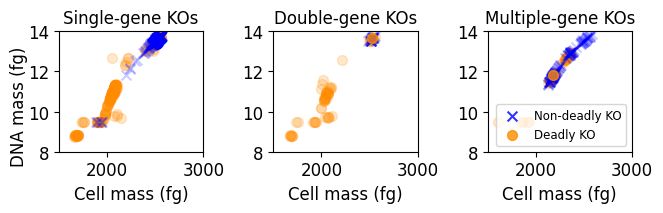

In [50]:
font = {'weight' : 'normal', 'size':12} 
plt.rc('font', **font)                                                                                          
plt.rcParams["figure.figsize"] = (6.61,2.3)


df_deadly_single = df_single[df_single["label_death"]=='deadly_gene'][['dnaMass', 'cellMass']]
df_not_deadly_single = df_single[df_single["label_death"]=='not_deadly'][['dnaMass', 'cellMass']]

df_deadly_double = df_double[df_double["label_death"]=='deadly_gene'][['dnaMass', 'cellMass']]
df_not_deadly_double = df_double[df_double["label_death"]=='not_deadly'][['dnaMass', 'cellMass']]

df_deadly_multi = df_minesweeper[df_minesweeper["label"]=='deadly_gene'][['dnaMass', 'cellMass']].dropna().astype(float)
df_not_deadly_multi = df_minesweeper[df_minesweeper["label"]=='not_deadly'][['dnaMass', 'cellMass']].dropna().astype(float)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#plt.figure(figsize=(4.91, 2.41))


ax1.scatter(df_deadly_single['cellMass'].str[-1], df_deadly_single['dnaMass'].str[-1], c='darkorange', s=50, alpha=0.2, marker='o')
ax1.scatter(df_not_deadly_single['cellMass'].str[-1], df_not_deadly_single['dnaMass'].str[-1], c='b', s=50, alpha = 0.2, marker='x')
ax1.set_xlim(1500,3000)
ax1.set_ylim(8,14)
ax1.set_xlabel('Cell mass (fg)')
ax1.set_title('Single-gene KOs', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)


ax2.scatter(df_deadly_double['cellMass'].str[-1], df_deadly_double['dnaMass'].str[-1], c='darkorange', s=50, alpha=0.2, marker='o')
ax2.scatter(df_not_deadly_double['cellMass'].str[-1], df_not_deadly_double['dnaMass'].str[-1], c='b', s=50, alpha = 0.2, marker='x')
ax2.scatter(df_not_deadly_double['cellMass'].iloc[0][-1], df_not_deadly_double['dnaMass'].iloc[0][-1], c='b', s=50, alpha = 0.8, marker='x', label='Non-deadly KO')
ax2.scatter(df_deadly_double['cellMass'].iloc[0][-1], df_deadly_double['dnaMass'].iloc[0][-1], c='darkorange', s=50, alpha=0.8, marker='o', label='Deadly KO')
ax2.set_xlim(1500,3000)
ax2.set_ylim(8,14)
ax2.set_xlabel('Cell mass (fg)')
ax2.set_title('Double-gene KOs', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

print(df_deadly_multi['cellMass'])
ax3.scatter(df_deadly_multi['cellMass'], df_deadly_multi['dnaMass'], c='darkorange', s=50, alpha=0.2, marker='o')
ax3.scatter(df_not_deadly_multi['cellMass'], df_not_deadly_multi['dnaMass'], c='b', s=50, alpha = 0.2, marker='x')
ax3.scatter(df_deadly_multi['cellMass'].iloc[0], df_deadly_multi['dnaMass'].iloc[0], c='b', s=50, alpha = 0.8, marker='x', label='Non-deadly KO')
ax3.scatter(df_not_deadly_multi['cellMass'].iloc[0], df_not_deadly_multi['dnaMass'].iloc[0], c='darkorange', s=50, alpha=0.8, marker='o', label='Deadly KO')
ax3.set_xlim(1500,3000)
ax3.set_ylim(8,14)
ax3.set_xlabel('Cell mass (fg)')
ax3.set_title('Multiple-gene KOs', fontsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='lower right', fontsize=8.5)

fig.tight_layout()
#fig.text(0.5, 0.015, 'Cell mass (fg)', ha='center', fontsize ='medium')
fig.text(0, 0.5, 'DNA mass (fg)', va='center', rotation='vertical', fontsize='medium')
fig.savefig('top_feat_distrib.png', dpi=800)

# Train with multiple KOs added to training set

In [51]:
df_multiple_train = df_multiple_train.drop_duplicates(subset=["cell_path"])


In [52]:
df_multiple_train[df_multiple_train['KO_id'].isna()]['cell_path']

118    /user/work/ig13470/out/red_6gen_retrain/20231212.125858__/double_knockout_001444/000000
126    /user/work/ig13470/out/red_6gen_retrain/20231212.125829__/double_knockout_000104/000000
128    /user/work/ig13470/out/red_6gen_retrain/20231212.125908__/double_knockout_001445/000000
Name: cell_path, dtype: object

In [53]:
combos_genes = pd.read_csv('/home/ig13470/Documents/5_percent_segments.csv', sep='\t', header=None)
combos_genes = combos_genes.rename(columns={0: "Segment", 1: "Genes"})

In [54]:
for ind, row in df_multiple_train.iterrows():
    genes = []
    for segment in row['Combos'].split(' '):
        genes.extend(combos_genes[combos_genes['Segment']==segment]['Genes'].values[0].split(' '))
    df_multiple_train.loc[ind, 'Genes'] = str(genes[:-1])

In [55]:
df_multiple_train.to_csv('multiple_ko_train.csv')

In [56]:
df_multiple_train = df_multiple_train.rename(columns={"label": "label_death"})
df_multiple_train = df_multiple_train[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
                                       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
                                       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
                                        'label_death', 'cell_path']]

In [57]:
df_multiple_train = df_multiple_train[~df_multiple_train.isna().any(axis=1)]
df_multiple_train['label_death'] = df_multiple_train['label_death'].replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})


In [58]:
font = {'weight' : 'normal', 'size':20} 
plt.rc('font', **font)    
plt.rcParams["figure.figsize"] = (2.45, 2.45)


In [59]:
from sklearn.model_selection import GroupShuffleSplit

X = df_features.drop([ 'label', 'cell', 'seed', 'instantaniousGrowthRate',
                       'label_lifetime', 'generation', 'gene_name'], axis=1)
y=df_features.label_death.replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
gs = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=6)

gen = list(next(gs.split(X, y, groups=X.gene_id)))
train_ix = gen[0]
test_ix = gen[1]

X_train = X.iloc[train_ix].drop(columns=['label_death'])
y_train = y.iloc[train_ix]

X_test = X.iloc[test_ix].drop(columns=['label_death'])
y_test = y.iloc[test_ix]

In [60]:
y_train.value_counts()

label_death
non_essential    438
essential        300
Name: count, dtype: int64

In [61]:
y_test.value_counts()

label_death
non_essential    102
essential         84
Name: count, dtype: int64

In [62]:
df_multiple_X = df_multiple_train[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
       'smallMoleculeMass', 'membrane_mass']]
df_multiple_y = df_multiple_train['label_death']

In [63]:
from sklearn.utils import shuffle

X_train = pd.concat([df_multiple_X, X_train])
y_train = pd.concat([df_multiple_y, y_train])



In [64]:
X_train.columns

Index(['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
       'smallMoleculeMass', 'membrane_mass', 'cell_path', 'gene_id'],
      dtype='object')

In [65]:

df_multiple_label_test = df_multiple_test['label'].replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
df_multiple_test = df_multiple_test[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
       'smallMoleculeMass', 'membrane_mass']]

In [66]:
y_train.value_counts()

label_death
non_essential    539
essential        447
Name: count, dtype: int64

Confussion matrix for the training set


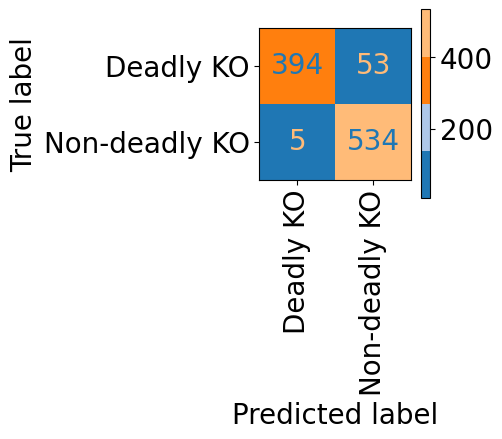

F1-score training  0.9314420803782507
confusion matrix for the test set


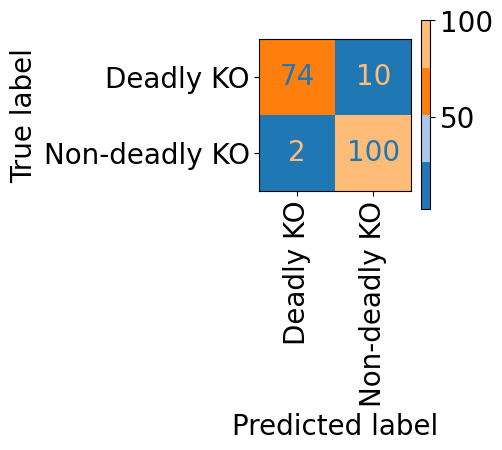

F1 score for the test set is 0.925
F1 score for the multiple set is 0.8750000000000001


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
import itertools

tr_acc=[]
test_single_acc= []
test_multiple_acc = []
hyperparams = []

#for x in itertools.product(list(range(2,20)), list(range(2,20))):
#    hyperparams.append(x)
clf = RandomForestClassifier(max_depth=6, n_estimators=3, random_state=0, class_weight='balanced')
clf.fit(X_train.drop(columns=['cell_path', 'gene_id']), y_train)

print('Confussion matrix for the training set')
cnf_tr = confusion_matrix(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_tr,
                               display_labels=['Deadly KO', 'Non-deadly KO'])

disp.plot(cmap=colors, xticks_rotation='vertical')
disp.figure_.savefig('confusion_matrix_training_retrained.png', bbox_inches="tight", dpi=600)
plt.show()
print('F1-score training ', f1_score(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))
tr_acc.append(f1_score(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))
print('confusion matrix for the test set')
cnf_test = confusion_matrix(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_test,
                               display_labels=['Deadly KO', 'Non-deadly KO'])

disp.plot(cmap=colors, xticks_rotation='vertical')
disp.figure_.savefig('confusion_matrix_test_retrained.png', bbox_inches="tight", dpi=600)
plt.show()
print('F1 score for the test set is ' + str(f1_score(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential')))
test_single_acc.append(f1_score(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))

print('F1 score for the multiple set is ' + str(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential')))
test_multiple_acc.append(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential'))

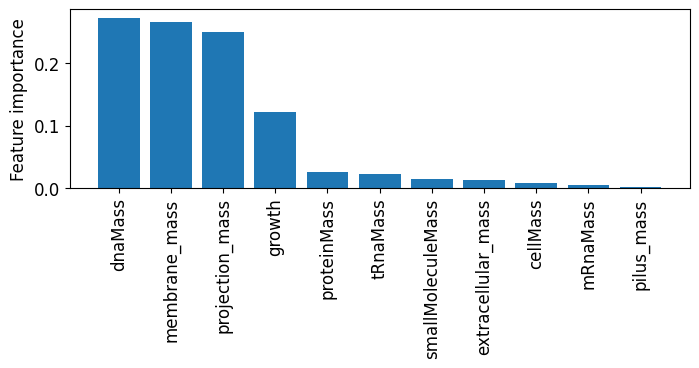

In [68]:
plt.rcParams["figure.figsize"] = (8, 2.32)

features = X_train.columns
f_i = list(zip(features,clf.feature_importances_))
f_i.sort(key = lambda x : x[1], reverse=True)
to_d = [t[0] for t in f_i if t[1]==0]
top_30 = [t[0] for t in f_i[:10]]
plt.bar(*zip(*f_i))
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Feature importance', fontsize=12)
plt.savefig('feat_importance_rf_retrained.png', bbox_inches="tight")
plt.savefig('feat_importance_rf_retrained.eps', bbox_inches="tight", format='eps')
plt.show()

# Test on double KOs

In [69]:
cols = ['cellMass', 'growth', 'dryMass', 'waterMass', 'dnaMass', 'cytosol_mass',
       'tRnaMass', 'extracellular_mass', 'rRnaMass', 'proteinMass',
       'projection_mass', 'rnaMass', 'outer_membrane_mass', 'flagellum',
       'pilus_mass', 'cellVolume', 'inner_membrane_mass', 'mRnaMass',
       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
       'periplasm_mass']

#this is for the cells that survive only for 1 time-step
df_double1 = df_double[df_double['cellMass'].str.len().isna()]
for c in cols:
    df_double1[c] = df_double1[c].astype(float)
    

#this is for the cells that survive for more than 1 time-step
df_double2 = df_double[~df_double['cellMass'].str.len().isna()]

for c in cols:
    df_double2[c] = df_double2[c].apply(lambda x:x[-1])


        
df_double_feat = pd.concat([df_double1, df_double2])
df_double_feat['growth'] = df_double_feat['growth'].fillna(0)
df_double_feat = df_double_feat.drop(columns=['processMassDifferences', 'time'])[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
       'smallMoleculeMass', 'membrane_mass']]



[[63 10]
 [ 0 21]]
F1 score for the double set is 0.9264705882352942


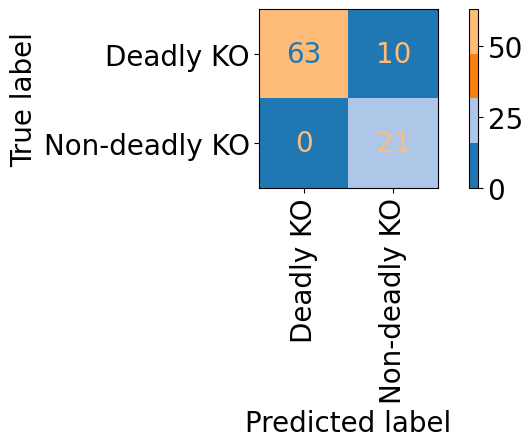

In [70]:

cnf_double = confusion_matrix(df_double_label, clf.predict(df_double_feat))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_double,
                               display_labels=['Deadly KO', 'Non-deadly KO'])
print(cnf_double)
disp.plot(cmap=colors, xticks_rotation='vertical', )
disp.figure_.savefig('confusion_matrix_doubleKO_retrain.png', bbox_inches="tight", dpi=600)

print('F1 score for the double set is ' + str(f1_score(df_double_label, clf.predict(df_double_feat),  pos_label='essential')))

# Test on multiple KOs

In [71]:
df_multiple_test = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_multiple_test_perms_final.pkl')
df_multiple_test = df_multiple_test.drop_duplicates(subset='Combos')[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
       'smallMoleculeMass', 'membrane_mass']]


[[28  8]
 [ 0 27]]
F1 score for the multiple set is 0.8750000000000001


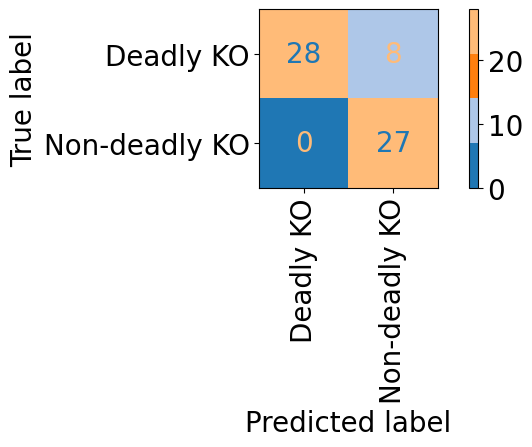

In [72]:
cnf_multiple = confusion_matrix(df_multiple_label_test, clf.predict(df_multiple_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_multiple,
                               display_labels=['Deadly KO', 'Non-deadly KO'])
print(cnf_multiple)
disp.plot(cmap=colors, xticks_rotation='vertical', )
disp.figure_.savefig('confusion_matrix_multipleKO_test_final.png', bbox_inches="tight", dpi=600)


print('F1 score for the multiple set is ' + str(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential')))

In [73]:
# save the model to disk
filename = 'rf_model_surrogate_retrained_new.sav'
pickle.dump(clf, open(filename, 'wb')) 

# Add more data to the training set as interations go along

In [74]:
df_multiple_train = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_multiple_train_perms_final.pkl')

df_multiple_train_st4_blue3 = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_for_retraining_stage4_blue3.pkl')
df_multiple_train_st4_red1 = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_for_retraining_stage4_red1.pkl')
df_multiple_train_st4_red3 = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_for_retraining_stage4_red3.pkl')
df_multiple_train_st4_yellow3 = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_for_retraining_stage4_yellow3.pkl')

df_multiple_train_st4 = pd.concat([df_multiple_train_st4_blue3, df_multiple_train_st4_red1, df_multiple_train_st4_red3, df_multiple_train_st4_yellow3])

In [75]:
len(df_multiple_train_st4)

59

In [76]:
df_multiple_train = pd.concat([df_multiple_train, df_multiple_train_st4])

In [77]:
df_multiple_train = df_multiple_train.rename(columns={"label": "label_death"})
df_multiple_train = df_multiple_train[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
                                       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
                                       'smallMoleculeMass', 'instantaniousGrowthRate', 'membrane_mass',
                                        'label_death', 'cell_path']]

In [78]:
df_multiple_train = df_multiple_train[~df_multiple_train.isna().any(axis=1)]
df_multiple_train['label_death'] = df_multiple_train['label_death'].replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})


In [79]:
from sklearn.model_selection import GroupShuffleSplit

X = df_features.drop([ 'label', 'cell', 'seed', 'instantaniousGrowthRate',
                       'label_lifetime', 'generation', 'gene_name'], axis=1)
y=df_features.label_death.replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
gs = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=6)

gen = list(next(gs.split(X, y, groups=X.gene_id)))
train_ix = gen[0]
test_ix = gen[1]

X_train = X.iloc[train_ix].drop(columns=['label_death'])
y_train = y.iloc[train_ix]

X_test = X.iloc[test_ix].drop(columns=['label_death'])
y_test = y.iloc[test_ix]

In [80]:
df_multiple_X = df_multiple_train[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
       'smallMoleculeMass', 'membrane_mass']]
df_multiple_y = df_multiple_train['label_death']

In [81]:
from sklearn.utils import shuffle

X_train = pd.concat([df_multiple_X, X_train])
y_train = pd.concat([df_multiple_y, y_train])

In [82]:
y_train.value_counts()

label_death
non_essential    560
essential        511
Name: count, dtype: int64

In [83]:
df_multiple_test = pd.read_pickle('/home/ig13470/Documents/WCM_data/df_multiple_test_perms_final.pkl')

df_multiple_label_test = df_multiple_test['label'].replace({'not_deadly': 'non_essential', 'deadly_gene': 'essential'})
df_multiple_test = df_multiple_test[['cellMass', 'growth', 'dnaMass', 'tRnaMass', 'extracellular_mass',
       'proteinMass', 'projection_mass', 'pilus_mass', 'mRnaMass',
       'smallMoleculeMass', 'membrane_mass']]

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
import itertools

tr_acc=[]
test_single_acc= []
test_multiple_acc = []
hyperparams = []

for x in itertools.product(list(range(2,20)), list(range(2,20))):
    hyperparams.append(x)
    clf = RandomForestClassifier(max_depth=x[0], n_estimators=x[1], random_state=14)
    clf.fit(X_train.drop(columns=['cell_path', 'gene_id']), y_train)
    
    print('Confussion matrix for the training set')
    cnf_tr = confusion_matrix(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_tr,
                                   display_labels=['Deadly KO', 'Non-deadly KO'])
    
    #disp.plot(cmap=colors, xticks_rotation='vertical')
    #disp.figure_.savefig('confusion_matrix_training_retrained.png', bbox_inches="tight", dpi=600)
    #plt.show()
    print('F1-score training ', f1_score(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))
    tr_acc.append(f1_score(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))
    print('confusion matrix for the test set')
    cnf_test = confusion_matrix(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_test,
                                   display_labels=['Deadly KO', 'Non-deadly KO'])
    
    #disp.plot(cmap=colors, xticks_rotation='vertical')
    #disp.figure_.savefig('confusion_matrix_test_retrained.png', bbox_inches="tight", dpi=600)
    #plt.show()
    print('F1 score for the test set is ' + str(f1_score(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential')))
    test_single_acc.append(f1_score(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))
    
    print('F1 score for the multiple set is ' + str(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential')))
    test_multiple_acc.append(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential'))

Confussion matrix for the training set
F1-score training  0.8998946259220232
confusion matrix for the test set
F1 score for the test set is 0.925
F1 score for the multiple set is 0.7777777777777778
Confussion matrix for the training set
F1-score training  0.90084388185654
confusion matrix for the test set
F1 score for the test set is 0.925
F1 score for the multiple set is 0.8571428571428571
Confussion matrix for the training set
F1-score training  0.8991596638655462
confusion matrix for the test set
F1 score for the test set is 0.925
F1 score for the multiple set is 0.8571428571428571
Confussion matrix for the training set
F1-score training  0.8991596638655462
confusion matrix for the test set
F1 score for the test set is 0.925
F1 score for the multiple set is 0.8571428571428571
Confussion matrix for the training set
F1-score training  0.8991596638655462
confusion matrix for the test set
F1 score for the test set is 0.925
F1 score for the multiple set is 0.8571428571428571
Confussion m

In [85]:
index_max = np.argmax(test_multiple_acc)

In [86]:
print(test_multiple_acc[index_max], test_single_acc[index_max], tr_acc[index_max])
print(hyperparams[index_max])

0.8750000000000001 0.925 0.9270298047276465
(3, 16)


Confussion matrix for the training set


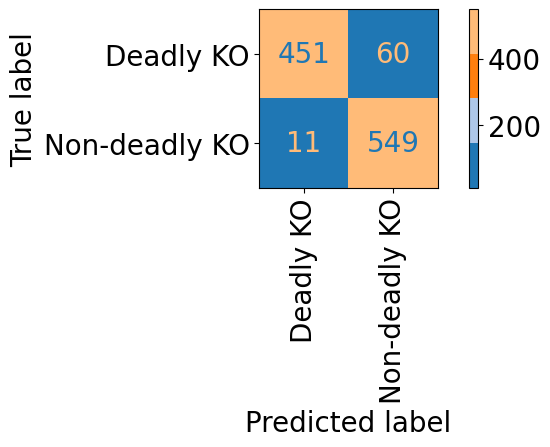

F1-score training  0.9270298047276465
confusion matrix for the test set


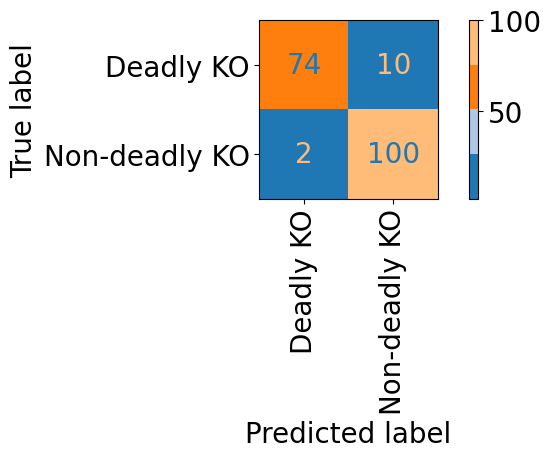

F1 score for the test set is 0.925
F1 score for the multiple set is 0.8750000000000001


In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
import itertools

tr_acc=[]
test_single_acc= []
test_multiple_acc = []
hyperparams = []

#for x in itertools.product(list(range(2,20)), list(range(2,20))):
clf = RandomForestClassifier(max_depth=3, n_estimators=16, random_state=14)
clf.fit(X_train.drop(columns=['cell_path', 'gene_id']), y_train)

print('Confussion matrix for the training set')
cnf_tr = confusion_matrix(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_tr,
                               display_labels=['Deadly KO', 'Non-deadly KO'])

disp.plot(cmap=colors, xticks_rotation='vertical')
disp.figure_.savefig('confusion_matrix_training_retrained.png', bbox_inches="tight", dpi=600)
plt.show()
print('F1-score training ', f1_score(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))
tr_acc.append(f1_score(y_train, clf.predict(X_train.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))
print('confusion matrix for the test set')
cnf_test = confusion_matrix(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_test,
                               display_labels=['Deadly KO', 'Non-deadly KO'])

disp.plot(cmap=colors, xticks_rotation='vertical')
disp.figure_.savefig('confusion_matrix_test_retrained.png', bbox_inches="tight", dpi=600)
plt.show()
print('F1 score for the test set is ' + str(f1_score(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential')))
test_single_acc.append(f1_score(y_test, clf.predict(X_test.drop(columns=['cell_path', 'gene_id'])),  pos_label='essential'))

print('F1 score for the multiple set is ' + str(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential')))
test_multiple_acc.append(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential'))

[[28  8]
 [ 0 27]]
F1 score for the multiple set is 0.8750000000000001


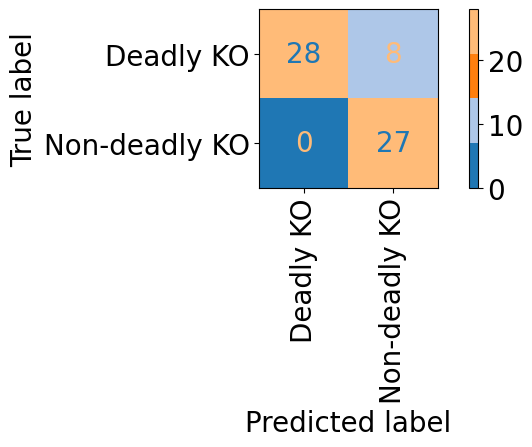

In [88]:
cnf_multiple = confusion_matrix(df_multiple_label_test, clf.predict(df_multiple_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_multiple,
                               display_labels=['Deadly KO', 'Non-deadly KO'])
print(cnf_multiple)
disp.plot(cmap=colors, xticks_rotation='vertical', )
disp.figure_.savefig('confusion_matrix_multipleKO_test_final.png', bbox_inches="tight", dpi=600)


print('F1 score for the multiple set is ' + str(f1_score(df_multiple_label_test, clf.predict(df_multiple_test),  pos_label='essential')))

In [89]:
# save the model to disk
filename = 'rf_model_surrogate_retrained_stage4.sav'
pickle.dump(clf, open(filename, 'wb')) 